# Line connectivity simulated experiments

This notebook will produce raw data to be post-processed and annealed on in the accompanying annealer file

### Things to keep in mind about designing the experiment

1. The theory we developed applies to the perturbative regime - we want to keep most of the errors small in the simulation to get a good extrapolation fit (thereby validating the theory work)
2. The simulated annealer shines the most when there is one state (circuit assignment) that is significantly better than the alternatives - in this case, the probability of randomly drawing the best state (which is not comparable to even the next best choice) is tiny, and so the performance of random guessing goes way down.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import multiprocessing

import cirq
import cirq_google as cg
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 

import qbitmap
from qbitmap import metrics
from qbitmap import utils
from qbitmap import calibration_data
from qbitmap.noise.simple_noise_model import SimpleNoiseModel
from qbitmap import circuits
from qbitmap import diagnostics
from qbitmap.noise.example_noise_models import make_noisegraph_twolocal_depol_noise_model
from qbitmap import io


PROJECT ID: fermilab-quantum
PROCESSOR:  >>> weber <<<
GATESET:    <cirq_google.serializable_gate_set.SerializableGateSet object at 0x7f52b42a4978>


### 1 Construct a sample error map to attempt

In [3]:
np.random.seed(4454)
# List the target qubits in flattened format
GOOD_QUBITS = [(3, 2), (2, 2), (2, 3), (1, 3), (1, 4)] + [(3, 0), (4, 4), (0, 1)]
# good edges: not necessarily connecting the good qubits
GOOD_EDGES = [(GOOD_QUBITS[i], GOOD_QUBITS[i+1]) for i in range(len(GOOD_QUBITS)-1)] \
    + [((3, 0), (2, 0)), ((4, 2), (4, 3))]
GOOD_EDGES = GOOD_EDGES + [(t[1], t[0]) for t in GOOD_EDGES]
WIDTH, HEIGHT = 5, 5
G = nx.grid_2d_graph(WIDTH, HEIGHT)
# G = nx.convert_node_labels_to_integers(G)

good_1q_base = 0.001
err_1q_base = 0.010

good_2q_base = 0.005
err_2q_base = 0.025

err_1q = np.asarray([good_1q_base if q in GOOD_QUBITS else np.random.normal(err_1q_base, .005)  for q in G.nodes])
err_2q = np.asarray([good_2q_base if e in GOOD_EDGES else np.random.normal(err_2q_base, 0.01)  for e in G.edges])

# FIXME: either I fucked up big or cirq allows negative depol parameters?
# I thought I put up an issue like 2 years ago on their github......
err_1q[err_1q <= 0] = 0
err_2q[err_2q <= 0] = 0

noise_1q = {'weight': err_1q}
noise_2q = {'weight': dict(zip(G.edges, err_2q))}

In [4]:
err_1q

array([0.00799498, 0.001     , 0.00853384, 0.01238432, 0.01653797,
       0.00753734, 0.01250595, 0.00876918, 0.001     , 0.001     ,
       0.00887297, 0.01296406, 0.001     , 0.001     , 0.00571829,
       0.001     , 0.01663518, 0.001     , 0.00751635, 0.00295699,
       0.00778798, 0.01947845, 0.0131944 , 0.01652342, 0.001     ])

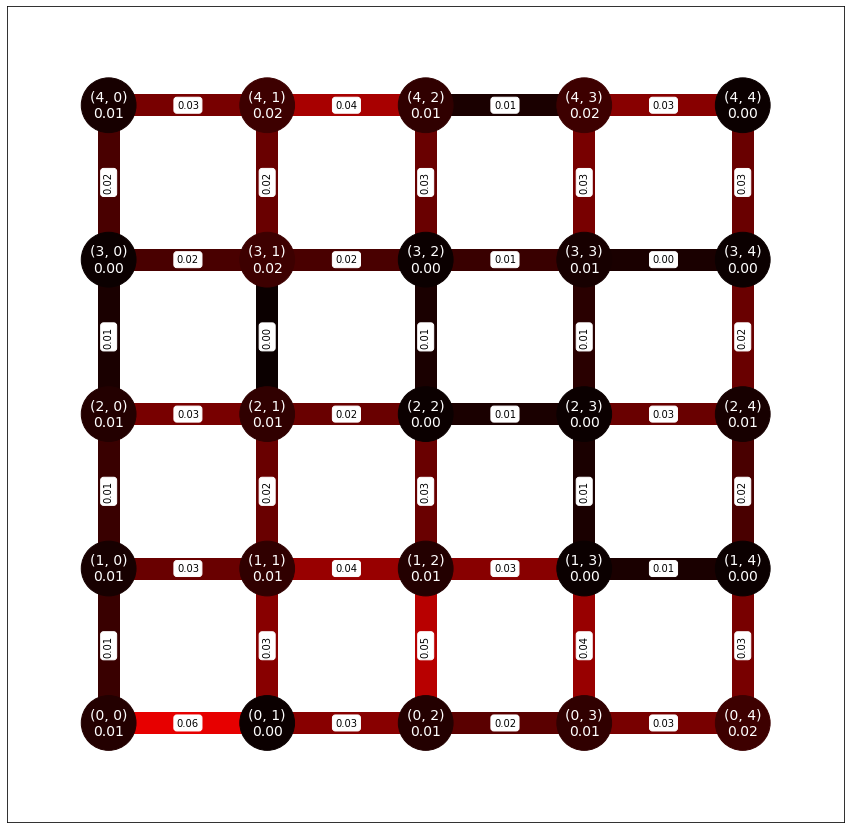

In [5]:
from qbitmap import noisemap 
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
noise_graph, coords = qbitmap.noisemap.make_nn_connected_from_inputs(WIDTH, HEIGHT, noise_1q, noise_2q)
noisemap.plot_nn_graph_with_noise(noise_graph, coords, ax=ax, metric_1q="weight", metric_2q="weight")
# fig.savefig("../figures/all_to_all_rand_anneal_noisegraph.pdf")

# SAVE THE NOISEGRAPH
#  The simulated annealer will at the very least require information about
# the graph connectivity. Doesn't hurt to include the noise values as well.
tag = "contrived"
nx.write_gpickle(noise_graph, f"./results/{tag}_noisemap.pkl")

## 2 Construct the circuits we'll be comparing

We will be running this annealer in much the same way as we do for hardware: Run simulations over the entire state space, and then perform annealing using a hash on those states.


#### Start with GHZ circuit

In [6]:
n_qubits = 5

noise_graph = nx.relabel_nodes(noise_graph, dict(zip(noise_graph.nodes, coords)))
# Pre-compute all of the paths
all_paths = []
for source in noise_graph.nodes():
    for target in noise_graph.nodes():
        if source == target:
            continue            
        all_paths_ij = list(nx.all_simple_paths(noise_graph, source, target, cutoff=n_qubits))
        for v in all_paths_ij:
            if len(v) == n_qubits:
                all_paths.append(v)

print("Found {} paths with {} qubits to attempt".format(len(all_paths), n_qubits))


Found 972 paths with 5 qubits to attempt


In [7]:
dm_sim = cirq.DensityMatrixSimulator()
qubits = cirq.GridQubit.rect(1, n_qubits)
noise_model = make_noisegraph_twolocal_depol_noise_model(noise_graph)

# Iterate over different kinds of circuits

circuit_names = ["random", "ghz"]
circuits = [
    circuits.create_random_line_circuit(qubits, 10),
    circuits.ghz_circuit_line_topology(qubits, measure=False, native=True)
]

for circuit, circuit_name in zip(circuits, circuit_names):
    def path_metrics(path):
            """Compute the relevant metrics F, FLE, F0 on a path.

            This is designed to be used in a multiprocessing context and is 
            therefore mostly self-contained.
            """

           # Construct the circuit on this path
            qubit_map = dict(zip(qubits, [cirq.GridQubit(*x) for x in path]))
            mapped_circuit = circuit.transform_qubits(qubit_map)

            # Compute naive fidelity
            F0 = metrics.compute_calibration_fidelity(mapped_circuit, noise_graph)

            # Compute true fidelity
            noisy_forward_circuit = mapped_circuit.with_noise(noise_model)
            F = metrics.compute_true_fidelity(mapped_circuit, noisy_forward_circuit, simulator=dm_sim)

            # Compute loschmidt fidelity (no sampling error)
            LE_circuit = mapped_circuit + cirq.inverse(mapped_circuit)
            noisy_LE_circuit = LE_circuit.with_noise(noise_model)
            F_LE = dm_sim.simulate(noisy_LE_circuit).final_density_matrix[0,0].real

            return F, F_LE, F0 

    # FIXME: I want to wrap up the async context in another function but
    # then the inner function isn't serializable?? 
    # dispatch = circuit_context(qubits, circuit, noise_model, dm_sim)


    # begin ASYNC
    PROCESSES = 4 # :((
    with multiprocessing.Pool(PROCESSES) as pool:
        results = [pool.apply_async(path_metrics, (path,)) for path in all_paths]
        out = np.asarray([r.get() for r in results])
        
    # Save the results
    tag = "contrived"
    path_fname, res_fname = io.make_experiment_fout(
        connectivity="line", 
        circuit_name=circuit_name, 
        n_qubits=n_qubits, 
        tag=tag, 
        path="./results")

    np.save(path_fname, all_paths)
    np.save(res_fname, out)


The results of the experiments should now be saved to the "./results" local directory.